# VG Recommender v1.0

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

## Content based filtering

In [2]:
# import game data
path = 'C:/Users/Jonah Melhado/Documents/Important Docs/BrainStation/Notebooks/proj_books/Capstone stuff/data/'
df = pd.read_csv(f'{path}/steam.csv')
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


For content based filtering, we need good descriptions of games in order to use tf-idf to find good matches. The code blocks below are being used to check the suitability of the available columns within the complete kaggle dataset.

In [20]:
# checking descriptions in data we already have
all_category_tags = []

for i in df_new['categories'].str.split(';'):
    for j in i:
        if j not in all_category_tags:
            all_category_tags.append(j)

all_category_tags
        

['Multiplayer',
 'Online Multiplayer',
 'Local Multiplayer',
 'Valve Anti-Cheat enabled',
 'Single-player',
 'Steam Cloud',
 'Steam Achievements',
 'Steam Trading Cards',
 'Captions available',
 'Partial Controller Support',
 'Includes Source SDK',
 'Cross-Platform Multiplayer',
 'Stats',
 'Commentary available',
 'Includes level editor',
 'Steam Workshop',
 'In-App Purchases',
 'Co-op',
 'Full controller support',
 'Steam Leaderboards',
 'SteamVR Collectibles',
 'Online Co-op',
 'Shared/Split Screen',
 'Local Co-op',
 'MMO',
 'VR Support',
 'Mods',
 'Mods (require HL2)',
 'Steam Turn Notifications']

The `categories` column is not representative of the game content

In [22]:
# checking genre column
all_genre_tags = []

for i in df['genres'].str.split(';'):
    for j in i:
        if j not in all_genre_tags:
            all_genre_tags.append(j)

all_genre_tags

['Action',
 'Free to Play',
 'Strategy',
 'Adventure',
 'Indie',
 'RPG',
 'Animation & Modeling',
 'Video Production',
 'Casual',
 'Simulation',
 'Racing',
 'Violent',
 'Massively Multiplayer',
 'Nudity',
 'Sports',
 'Early Access',
 'Gore',
 'Utilities',
 'Design & Illustration',
 'Web Publishing',
 'Education',
 'Software Training',
 'Sexual Content',
 'Audio Production',
 'Game Development',
 'Photo Editing',
 'Accounting',
 'Documentary',
 'Tutorial']

The `genre` column is superior in descriptiveness to the `categories` column, however it still lacks the required descriptiveness

In [92]:
# checking steamspy tags
all_steamspy_tags = []

for i in df['steamspy_tags'].str.split(';'):
    for j in i:
        if j not in all_steamspy_tags:
            all_steamspy_tags.append(j)
print(len(all_steamspy_tags))
            
sorted(all_steamspy_tags)

339


['1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '360 Video',
 '3D',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'Abstract',
 'Action',
 'Action RPG',
 'Action-Adventure',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'America',
 'Animation & Modeling',
 'Anime',
 'Arcade',
 'Arena Shooter',
 'Assassin',
 'Atmospheric',
 'Audio Production',
 'BMX',
 'Base-Building',
 'Baseball',
 'Basketball',
 'Batman',
 'Battle Royale',
 "Beat 'em up",
 'Beautiful',
 'Benchmark',
 'Bikes',
 'Blood',
 'Board Game',
 'Bowling',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Cats',
 'Character Action Game',
 'Character Customization',
 'Chess',
 'Choices Matter',
 'Choose Your Own Adventure',
 'Cinematic',
 'City Builder',
 'Class-Based',
 'Classic',
 'Clicker',
 'Co-op',
 'Cold War',
 'Colorful',
 'Comedy',
 'Comic Book',
 'Competitive',
 'Controller',
 'Conversation',
 'Crafting',
 '

These description fields are better than the previous columns. However, looking at the steam store there is a better field called user-defined tags that would probably yield more consistent results for a content recommender. So below is a web scraper function built to acquire the user-defined tags for each game.

In [61]:
import requests
from bs4 import BeautifulSoup

# intakes dataframe and returns a new dataframe with game title and tags
def get_user_tags(game_ids):
    
    app_list = game_ids['appid']
    app_names = game_ids['name']
    
    # creating
    df = pd.DataFrame()
    df['title'] = game_ids['name']
    
    tags = []
    
    for i in app_list:
        
        # print app name 
        print(f'\rCurrent App: {i}', end="")
        
        # get game page content
        response = requests.get(f'https://store.steampowered.com/app/{i}/')
        
        # create soup object
        soup = BeautifulSoup(response.content)
        
        # getting all tags
        desc = soup.find_all('div', class_='glance_tags popular_tags')
        
        # converting html response to text string
        try:
            desc = desc[0].get_text().replace('\t', '').replace('\n', '').replace('\r', ', ').replace('+', '')[2:]
            tags.append(desc)
        except:
            tags.append(None)
            
    df['tags'] = tags
    
    return df

In [62]:
# getting columns for tag retrieval function
df_desc = df[['appid', 'name']]

In [63]:
# retrieving all tags for each game above
df_descriptions = get_user_tags(df_desc)

Current App: 1069460

In [3]:
# Checking tags
all_tags = []

for i in df_descriptions['tags'].str.split(', '):
    try:
        for j in i:
            if j not in all_tags:
                all_tags.append(j)
    except:
        pass
print(len(all_tags))
sorted(all_tags)

424


['1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '2D Platformer',
 '360 Video',
 '3D',
 '3D Fighter',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'ATV',
 'Abstract',
 'Action',
 'Action RPG',
 'Action RTS',
 'Action Roguelike',
 'Action-Adventure',
 'Addictive',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'Ambient',
 'America',
 'Animation & Modeling',
 'Anime',
 'Arcade',
 'Archery',
 'Arena Shooter',
 'Artificial Intelligence',
 'Assassin',
 'Asymmetric VR',
 'Asynchronous Multiplayer',
 'Atmospheric',
 'Audio Production',
 'Auto Battler',
 'Automation',
 'Automobile Sim',
 'BMX',
 'Base Building',
 'Baseball',
 'Based On A Novel',
 'Basketball',
 'Batman',
 'Battle Royale',
 "Beat 'em up",
 'Beautiful',
 'Benchmark',
 'Bikes',
 'Blood',
 'Board Game',
 'Bowling',
 'Boxing',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Card Battler',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Cats',
 'Character Action 

These tags are applied by users so they are most likely more representative of the actual game content to a prospective user of the recommender.

In [65]:
# writing to csv
df_descriptions.to_csv(f'C:/Users/Jonah Melhado/Documents/Important Docs/BrainStation/Notebooks/proj_books/Capstone stuff/data/app_descriptions.csv', index=False)

In [2]:
# Checking descriptions
df_descriptions = pd.read_csv('C:/Users/Jonah Melhado/Documents/Important Docs/BrainStation/Notebooks/proj_books/Capstone stuff/data/app_descriptions.csv')
df_descriptions.head(10)

,title,tags
0,Counter-Strike,"Action, FPS, Multiplayer, Shooter, Classic, Te..."
1,Team Fortress Classic,"Action, FPS, Multiplayer, Classic, Hero Shoote..."
2,Day of Defeat,"FPS, World War II, Multiplayer, Shooter, Actio..."
3,Deathmatch Classic,"Action, FPS, Classic, Multiplayer, Shooter, Fi..."
4,Half-Life: Opposing Force,"FPS, Action, Classic, Sci-fi, Singleplayer, Sh..."
5,Ricochet,"Action, FPS, Multiplayer, Masterpiece, Classic..."
6,Half-Life,"FPS, Classic, Action, Sci-fi, Masterpiece, Sin..."
7,Counter-Strike: Condition Zero,"Action, FPS, Shooter, Multiplayer, First-Perso..."
8,Half-Life: Blue Shift,"FPS, Action, Sci-fi, Singleplayer, Shooter, Al..."
9,Half-Life 2,"FPS, Action, Sci-fi, Classic, Masterpiece, Sin..."


In [20]:
df_descriptions['tags'] = df_descriptions['tags'].astype(str)

In [22]:
# creating dataframe of tags to plot frequency of each
tag_frequency = []

for tag in all_tags:
    
    count = 0
    
    for i in df_descriptions['tags']:
        if tag in i:
            count += 1
    
    tag_frequency.append(count)

tags = {'tag':all_tags, 'frequency':tag_frequency}
    
df_tags = pd.DataFrame(tags)

df_tags.head()
    

,tag,frequency
0,Action,12375
1,FPS,1350
2,Multiplayer,3943
3,Shooter,2356
4,Classic,1261


In [27]:
df_tags.sort_values(by='frequency', ignore_index=True, inplace=True, ascending=False)

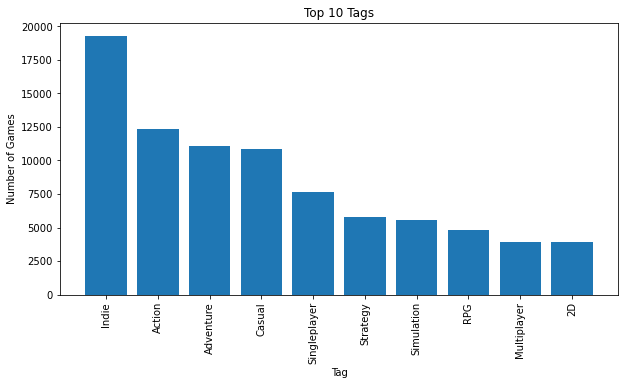

In [32]:
plt.figure(figsize=(10,5))
plt.bar(df_tags['tag'][0:10], df_tags['frequency'][0:10])
plt.xlabel('Tag')
plt.ylabel('Number of Games')
plt.title('Top 10 Tags')
plt.xticks(rotation=90)
plt.show()

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Helper function to look up game index in the sparse matrix using the title
def get_game_by_title(title, tfidf_scores, keys):
    row_id = keys[title]
    row = tfidf_scores[row_id,:]
    return row

# instantiate vectorizer
to_vec = TfidfVectorizer()

index = 0
keys = {}

# create dictionary of keys to retrieve game titles and vectors
for game in df_descriptions.itertuples():
    key = game[1]
    keys[key] = index
    index += 1

# fitting vectorizer
to_vec.fit(df_descriptions['tags'].fillna(''))

# transforming data
tfidf_scores = to_vec.transform(df_descriptions['tags'].fillna(''))

# recommender function
def recommend_content(title, tfidf_scores, games):
    
    # dataframe for result storage
    recommended = pd.DataFrame(columns=['title',f'similarity to {title}'])
    
    # use helper function to find game
    game1 = get_game_by_title(title, tfidf_scores, keys)
    
    # loop through all games and get similarities
    for i in games['name']:
        
        # find similarity
        game2 = get_game_by_title(i, tfidf_scores, keys)
        sim_score = cosine_similarity(game1,game2)
        recommended.loc[len(recommended)] = [i, sim_score[0][0]]
    
    # returning dataframe with similarity scores and titles
    result = recommended.sort_values(by=[f'similarity to {title}'], ascending=False)[1:].reset_index(drop=True)
    
    return result

        

In [107]:
# v1.0 recommending based on content similarity, no quality modification
recommend_content('Counter-Strike', tfidf_scores, df).head(10)

,title,similarity to Counter-Strike
0,Counter-Strike: Source,0.604835
1,Riot Street,0.548117
2,Counter-Strike: Condition Zero,0.544585
3,Tom Clancy's Rainbow Six® 3 Gold,0.519509
4,Quake III Arena,0.511771
5,Quake Live™,0.500169
6,Aim Hero,0.498455
7,Counter-Strike: Global Offensive,0.473652
8,Delta Force 2,0.470354
9,Deathmatch Classic,0.466584


In [80]:
# v1.1 recommending based on content similarity, with quality modification
recommend_content('Counter-Strike', tfidf_scores, df[df['positive_ratings'] + df['negative_ratings'] > 2000]).head(10)

,title,similarity to Counter-Strike
9,Counter-Strike: Source,0.604835
6,Counter-Strike: Condition Zero,0.544585
719,Quake Live™,0.500169
1373,Aim Hero,0.498455
23,Counter-Strike: Global Offensive,0.473652
406,Insurgency,0.456096
1119,Umbrella Corps™/Biohazard Umbrella Corps™,0.441052
31,QUAKE,0.438547
97,Unreal Tournament: Game of the Year Edition,0.432395
1412,Black Squad,0.424600


It is difficult to actually assign an accuracy to this data but recommenders are notoriously difficult to assess without actual user input. Moving forward this will be tested on different gamers so a more qualitative analysis can be performed.